<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/MLP_mnist_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize the features and parameters of the trained MLP



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np

In [19]:
# load MNIST data
train_Dataset = dsets.MNIST(
      root='./data',  # rootで指定したフォルダーを作成して生データを展開
      train=True,  # 学習かテストかの選択
      transform=transforms.ToTensor(),  # PyTroch のテンソルに変換
      download=True)  # ダウンロードするかどうかの選択

test_dataset = dsets.MNIST(
      root='./data',
      train=False,
      transform=transforms.ToTensor(),
      download=True)

train_dataset, valid_dataset = torch.utils.data.random_split(  # データセットの分割
      train_Dataset,   # 分割するデータセット
      [48000, 12000])  # 分割数

print('train_dataset = ', len(train_dataset))
print('valid_dataset = ', len(valid_dataset))
print('test_dataset = ', len(test_dataset))


train_dataset =  48000
valid_dataset =  12000
test_dataset =  10000


In [20]:
# set data loader
batch_size=64
train_loader = torch.utils.data.DataLoader(
      dataset=train_dataset,  # データセットの指定
      batch_size=batch_size,  # ミニバッチの指定
      shuffle=True,  # シャッフルするかどうかの指定
      num_workers=2)  # コアの数

valid_loader = torch.utils.data.DataLoader(
      dataset=valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=2)

test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=2)

In [21]:
# Multi Layer Perceptron Network
class MLPNet (nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, 128)
        self.fc2 = nn.Linear(128, 10)
#        self.dropout = nn.Dropout2d(0.4)

    def forward(self, x):
        y = torch.relu(self.fc1(x))
#        y = torch.sigmoid(self.fc1(x))
#        y = torch.tanh(self.fc1(x))
#        y = self.dropout1(y)
        z = self.fc2(y)
        return z


In [22]:
# Load the saved model from the file
#net = Net()
#net.load_state_dict(torch.load(PATH, weights_only=True))
#net.to(device)
# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#net = MLPNet().to(device)
#if device == 'cpu':
#    net = torch.load('./trained_models/MLP_mnist.pth', map_location=torch.device('cpu'), weights_only=False)
#else:
#    net = torch.load('./trained_models/MLP_mnist.pth', weights_only=False)
net = MLPNet()
net.load_state_dict(torch.load('./trained_models/MLP_mnist.pth', weights_only=False))
net.to(device)

print(device)
print(net)

# optimizing
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
optimizer = optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.01)


cpu
MLPNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# PCA for output features

In [23]:
# ======== eval_mode (train samples) ======
net.eval()
train_features = np.zeros((len(train_dataset), 10))
train_labels = np.zeros(len(train_dataset), dtype=int)

with torch.no_grad():
    total = 0
    acc = 0
    i = 0
    for images, labels in train_loader:        
        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        outputs = net(images)
        acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
        len_batch = len(images)
        train_features[i:i+len_batch] = outputs.cpu().detach().numpy()
        train_labels[i:i+len_batch] = labels.cpu().detach().numpy()
        i += len_batch
    print('train_accuracy: {} %'.format(100 * acc / total)) 

print(train_features.shape)
print(train_labels.shape)

train_accuracy: 98.71875 %
(48000, 10)
(48000,)


In [24]:
# ======== eval_mode (test samples) ======
net.eval()
test_features = np.zeros((len(test_dataset), 10))
test_labels = np.zeros(len(test_dataset), dtype=int)

with torch.no_grad():
    total = 0
    acc = 0
    i = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        outputs = net(images)
        acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
        len_batch = len(images)
        test_features[i:i+len_batch] = outputs.cpu().detach().numpy()
        test_labels[i:i+len_batch] = labels.cpu().detach().numpy()
        i += len_batch
    print('test_accuracy: {} %'.format(100 * acc / total)) 

print(test_features.shape)
print(test_labels.shape)

test_accuracy: 97.02 %
(10000, 10)
(10000,)


In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## PCA
pca = PCA(n_components=2)
#pca = PCA(n_components=2, svd_solver='randomized')
train_pca_score = pca.fit(train_features).transform(train_features)
#print(pca.singular_values_)
print('Explained Variance Ratio\n', pca.explained_variance_ratio_)

test_pca_score = pca.transform(test_features)
#print(train_pca_score)
#print(test_pca_score)

Explained Variance Ratio
 [0.26788952 0.22133564]


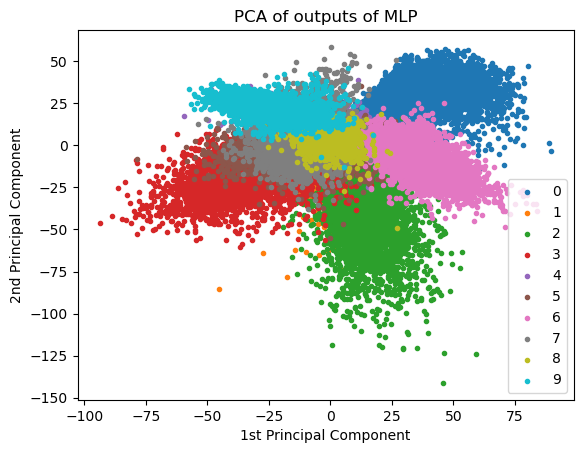

In [26]:
nclass = 10
#colors = np.random.rand(nclass) * 500000000000
colors = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']

## plot
plt.figure()
for k in range(nclass):
    plt.scatter(train_pca_score[train_labels == k, 0], train_pca_score[train_labels == k, 1], marker='.', label=k)
#plt.scatter(train_features[:, 0], train_features[:, 1], c=colors[train_labels], marker=".", label=colors)
plt.legend()
plt.title('PCA of outputs of MLP')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.savefig('MLP_mnist_train_features.png')
plt.show()

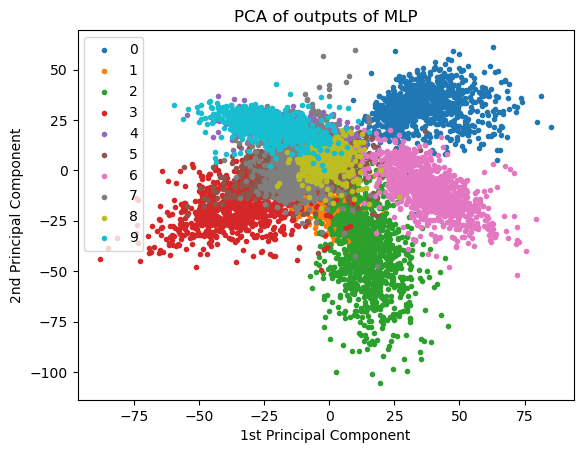

In [27]:
nclass = 10
#colors = np.random.rand(nclass) * 500000000000
colors = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']


## plot
plt.figure()
for k in range(nclass):
    plt.scatter(test_pca_score[test_labels == k, 0], test_pca_score[test_labels == k, 1], marker='.', label=k)
#plt.scatter(train_features[:, 0], train_features[:, 1], c=colors[train_labels], marker=".", label=colors)
plt.legend()
plt.title('PCA of outputs of MLP')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.savefig('MLP_mnist_test_features.png')
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix

test_predicted = test_features.argmax(1)
#print(test_predicted)
#print(test_labels)
print('Confusion Matrix for Test Samples\n', confusion_matrix(test_labels, test_predicted))

Confusion Matrix for Test Samples
 [[ 964    0    0    0    0    4    4    2    4    2]
 [   0 1119    4    1    0    1    3    1    5    1]
 [  10    0  998    5    0    2    2   11    3    1]
 [   1    0    6  974    0   10    0    7    6    6]
 [   1    1    3    1  949    0    7    3    2   15]
 [   2    0    0    8    2  865   11    0    2    2]
 [   4    3    1    0    2    7  938    1    2    0]
 [   2    3    5    1    7    1    0  999    0   10]
 [  10    2    7    6    5    6    6    5  922    5]
 [   2    3    0    3   15    2    0    6    4  974]]


# Visualization of each dimension of the output feature vector as Histogram

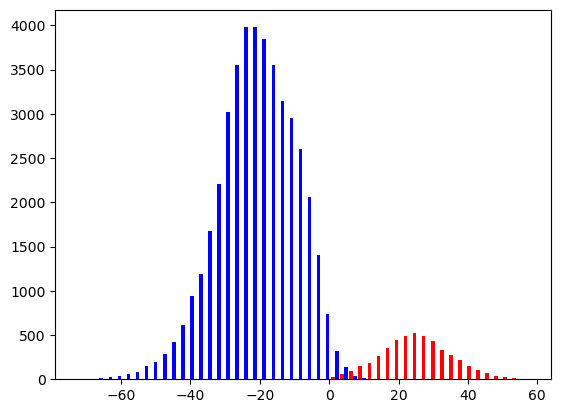

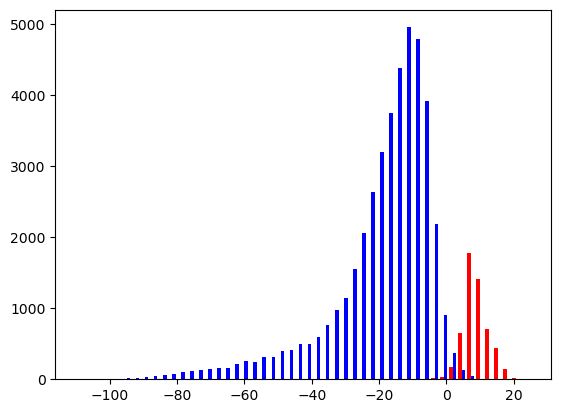

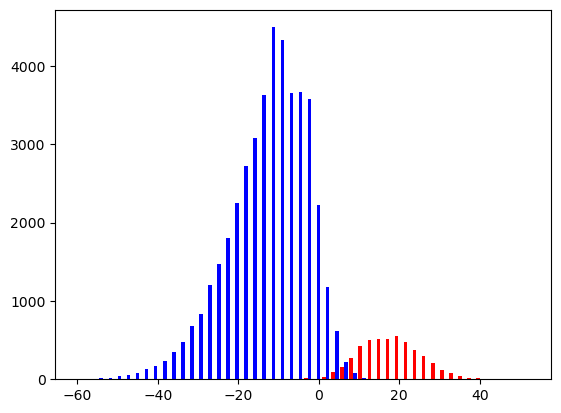

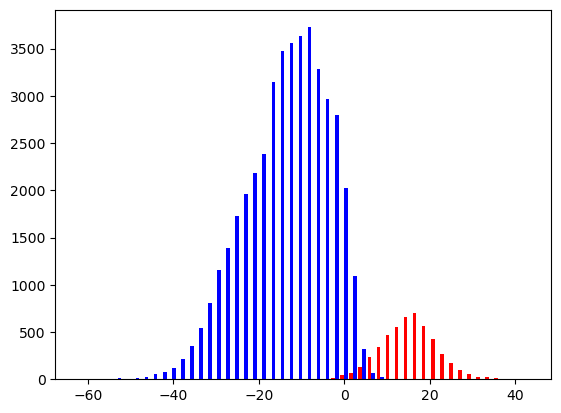

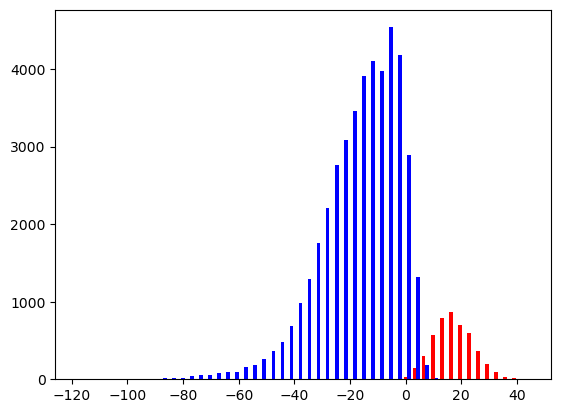

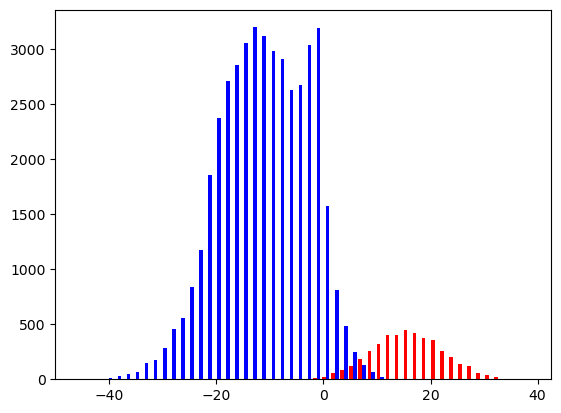

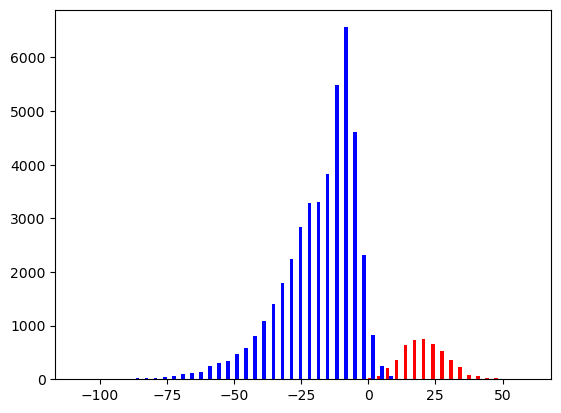

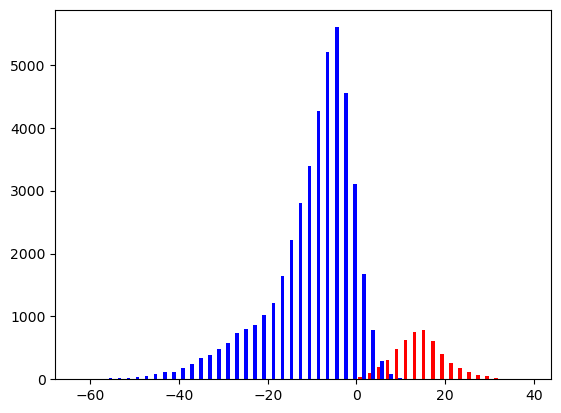

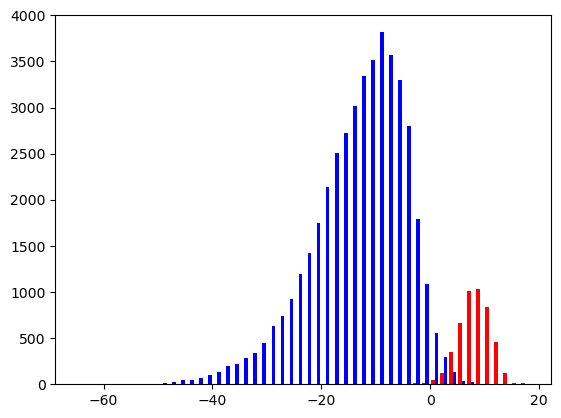

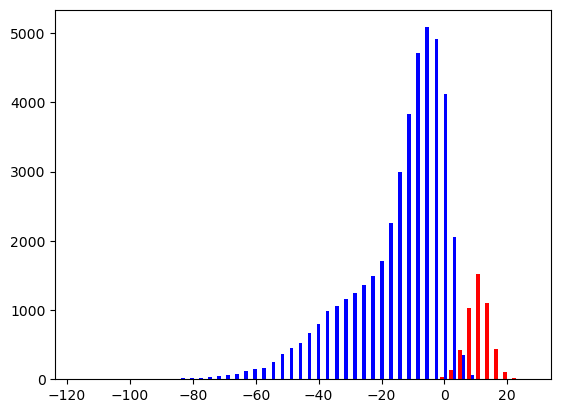

In [29]:
# Histogram of each output values
for k in range(nclass):
  plt.hist([train_features[train_labels == k, k], train_features[train_labels != k, k]], bins=50, color=['red', 'blue'])
  plt.show()

# Visualize feature vectors in the first layer (Before ReLU) by PCA

In [30]:
# ======== eval_mode (train samples) ======
net.eval()
train_fc1_features = np.zeros((len(train_dataset), 128))
train_fc1_labels = np.zeros(len(train_dataset), dtype=int)

with torch.no_grad():
    i = 0
    for images, labels in train_loader:        
        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        outputs = net.fc1(images)
        len_batch = len(images)
        train_fc1_features[i:i+len_batch] = outputs.cpu().detach().numpy()
        train_fc1_labels[i:i+len_batch] = labels.cpu().detach().numpy()
        i += len_batch

print(train_fc1_features.shape)
print(train_fc1_labels.shape)

(48000, 128)
(48000,)


In [31]:
# ======== eval_mode (test samples) ======
net.eval()
test_fc1_features = np.zeros((len(test_dataset), 128))
test_fc1_labels = np.zeros(len(test_dataset), dtype=int)

with torch.no_grad():
    i = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        outputs = net.fc1(images)
        len_batch = len(images)
        test_fc1_features[i:i+len_batch] = outputs.cpu().detach().numpy()
        test_fc1_labels[i:i+len_batch] = labels.cpu().detach().numpy()
        i += len_batch

print(test_fc1_features.shape)
print(test_fc1_labels.shape)

(10000, 128)
(10000,)


In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## PCA
pca = PCA(n_components=2)
#pca = PCA(n_components=2, svd_solver='randomized')
train_fc1_pca_score = pca.fit(train_fc1_features).transform(train_fc1_features)
#print(pca.singular_values_)
print('Explained Variance Ratio\n', pca.explained_variance_ratio_)

test_fc1_pca_score = pca.transform(test_fc1_features)
#print(train_pca_score)
#print(test_pca_score)

Explained Variance Ratio
 [0.25258629 0.12830579]


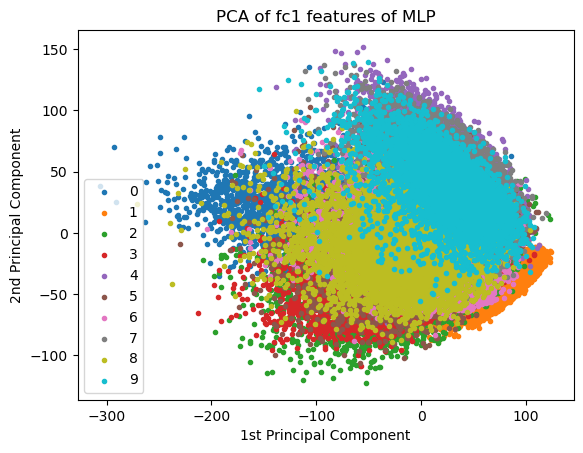

In [33]:
nclass = 10
#colors = np.random.rand(nclass) * 500000000000
colors = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']

## plot
plt.figure()
for k in range(nclass):
    plt.scatter(train_fc1_pca_score[train_fc1_labels == k, 0], train_fc1_pca_score[train_fc1_labels == k, 1], marker='.', label=k)
#plt.scatter(train_features[:, 0], train_features[:, 1], c=colors[train_labels], marker=".", label=colors)
plt.legend()
plt.title('PCA of fc1 features of MLP')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.savefig('MLP_mnist_train_fc1_features.png')
plt.show()

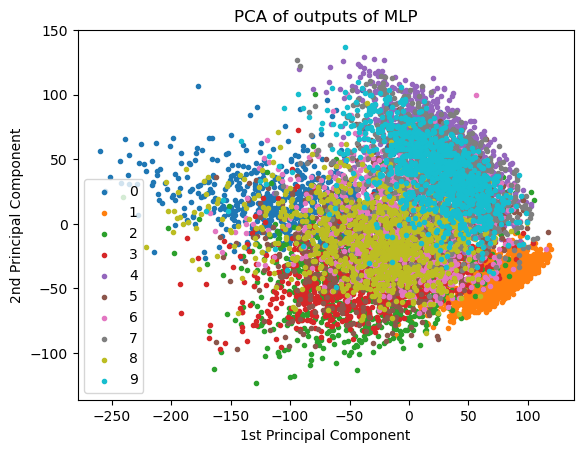

In [34]:
nclass = 10
#colors = np.random.rand(nclass) * 500000000000
colors = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']


## plot
plt.figure()
for k in range(nclass):
    plt.scatter(test_fc1_pca_score[test_fc1_labels == k, 0], test_fc1_pca_score[test_fc1_labels == k, 1], marker='.', label=k)
#plt.scatter(train_features[:, 0], train_features[:, 1], c=colors[train_labels], marker=".", label=colors)
plt.legend()
plt.title('PCA of outputs of MLP')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.savefig('MLP_mnist_test_fc1_features.png')
plt.show()

# Visualize the trained weights as Histogram



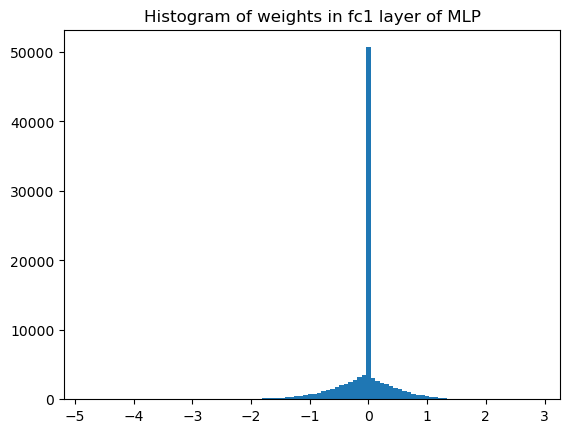

In [49]:
# weights in fc1 layer
plt.hist(net.fc1.weight.detach().numpy().reshape(128 * 784), bins=100)
plt.title('Histogram of weights in fc1 layer of MLP')
plt.savefig('MLP_mnist_fc1_weights.png')
plt.show()

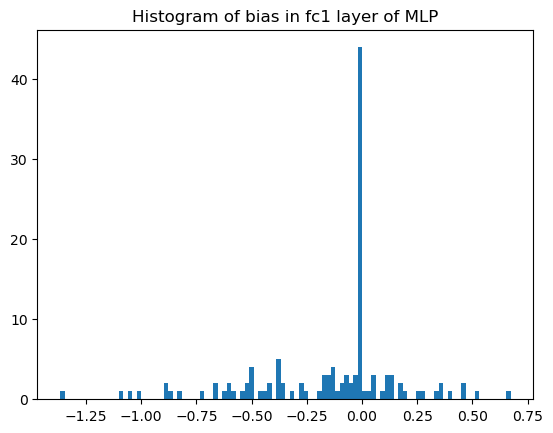

In [50]:
# bias in fc1 layer
plt.hist(net.fc1.bias.detach().numpy(), bins=100)
plt.title('Histogram of bias in fc1 layer of MLP')
plt.savefig('MLP_mnist_fc1_bias.png')
plt.show()

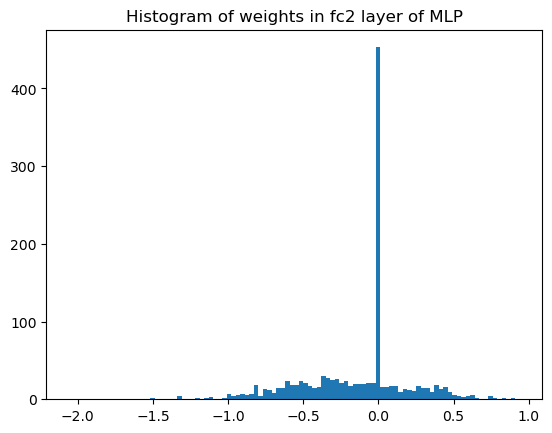

In [51]:
# weights in fc2 layer
plt.hist(net.fc2.weight.detach().numpy().reshape(128 * 10), bins=100)
plt.title('Histogram of weights in fc2 layer of MLP')
plt.savefig('MLP_mnist_fc2_weights.png')
plt.show()

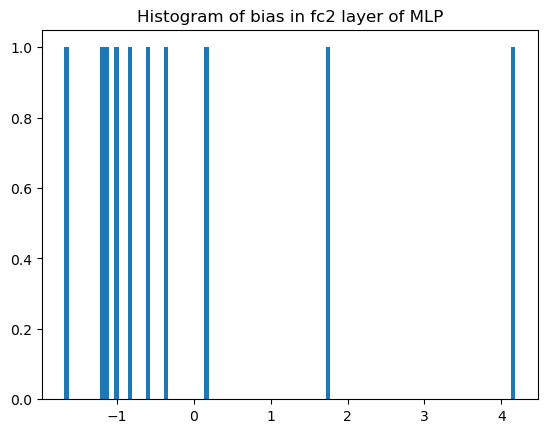

In [52]:
# bias in fc1 layer
plt.hist(net.fc2.bias.detach().numpy(), bins=100)
plt.title('Histogram of bias in fc2 layer of MLP')
plt.savefig('MLP_mnist_fc2_bias.png')
plt.show()